In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(tidyverse))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(data.table))

In [2]:
seu_intd_wt = readRDS(file = "../data/intd_seu_objects/1_6_22_WT.rds")

In [3]:
resolution = 1.25
set.seed(42)
DefaultAssay(seu_intd_wt) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
#seu_intd_wt <- ScaleData(seu_intd_wt, verbose = FALSE)
seu_intd_wt <- RunPCA(seu_intd_wt, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_wt <- FindNeighbors(seu_intd_wt, dims = 1:20, verbose = FALSE)
seu_intd_wt <- FindClusters(seu_intd_wt, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_wt <- RunUMAP(seu_intd_wt, reduction = "pca", dims = 1:20, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [20]:
known.good.markers <- read.csv("../data/cell_type_markers/markers.csv", header = F)
colnames(known.good.markers) = c("Name", "Locus", "Celltype")
known.good.markers <- known.good.markers[known.good.markers$Locus %in% rownames(seu_intd_wt@assays$RNA),]
known.good.markers$Celltype <- gsub("abscission_zone", "Abscission Zone", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("companion_cells", "Companion Cells", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("xylem", "Xylem", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("phloem", "Phloem", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("vascular_subtype_1", "Vascular Subtype", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("epidermis", "Epidermis", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("sieve_element", "Sieve Element", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("tracheary_element", "Tracheary Element", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("mesophyll", "Mesophyll", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("guard_cells", "Guard Cells", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);

In [ ]:
known.good.markers

In [25]:
zscore <- function(x){(x-mean(x))/sd(x)}

msc <- c()
for (i in as.character(unique(known.good.markers$Celltype))){
    if (length(known.good.markers[which(known.good.markers$Celltype== i),]$Locus)>1){
    msc <- cbind(msc, as.numeric(apply(apply(seu_intd_wt@assays$SCT@data[known.good.markers[which(known.good.markers$Celltype== i),]$Locus,], 1, zscore), 1, mean)))       
    } else {
    msc <- cbind(msc, as.numeric(zscore(seu_intd_wt@assays$SCT@data[known.good.markers[which(known.good.markers$Celltype== i),]$Locus,])))      
    }

}
colnames(msc) <- as.character(unique(known.good.markers$Celltype))
rownames(msc) <- colnames(seu_intd_wt)

In [27]:
# Find clusters, here we choose Leiden clustering algorithm with resolution 0.5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
DefaultAssay(seu_intd_wt) <- "integrated"
suppressMessages(suppressWarnings(
  seu_intd_wt <- FindClusters(seu_intd_wt, resolution = 2, algorithm = 3)
))

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16169
Number of edges: 506288

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8315
Number of communities: 38
Elapsed time: 10 seconds


In [28]:
anno <- seu_intd_wt$seurat_clusters
for (i in unique(seu_intd_wt$seurat_clusters)){
    if (max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean))>0){
        ct <- names(which.max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean)))
    } else {
        ct <- "NA"
    }
        anno <- gsub(paste0("^",i,"$"), ct, anno, ignore.case = FALSE, perl = FALSE,fixed = FALSE, useBytes = FALSE)
}


In [29]:
seu_intd_wt$score.crude.anno <- anno

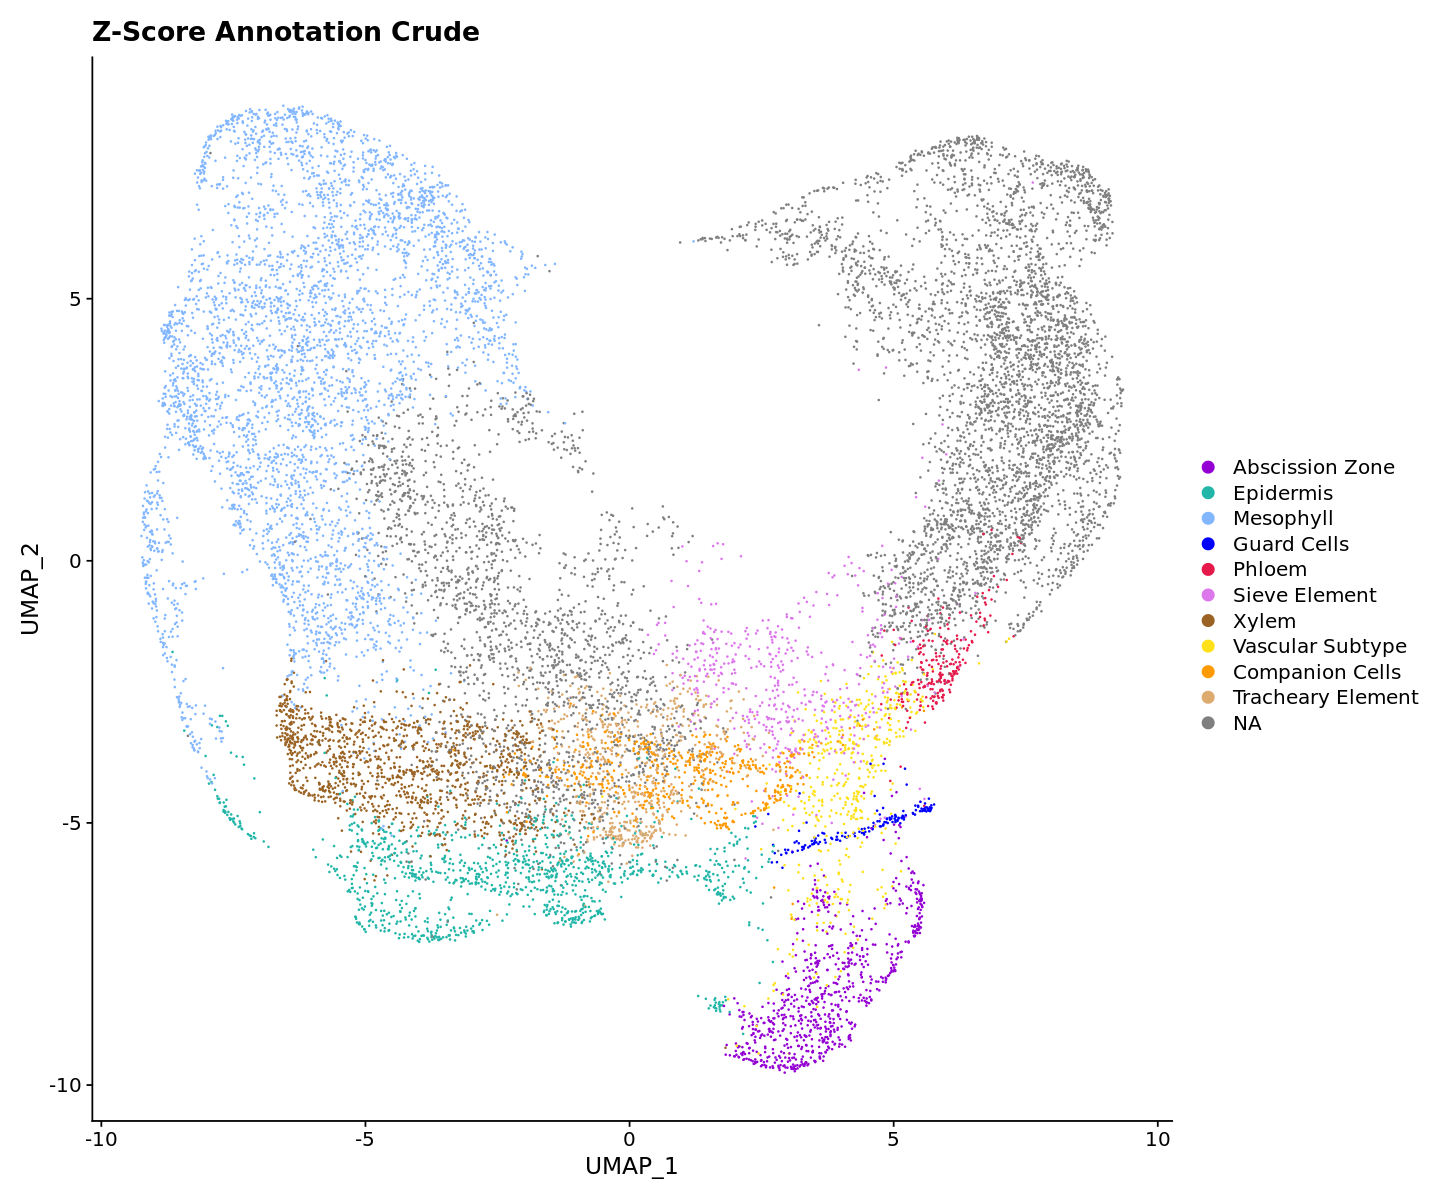

In [30]:
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Epidermis", "Mesophyll", "Guard Cells", "Phloem","Sieve Element", "Xylem", "Vascular Subtype","Companion Cells","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$score.crude.anno <- factor(seu_intd_wt$score.crude.anno , levels = order[sort(match(unique(seu_intd_wt$score.crude.anno),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$score.crude.anno),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "score.crude.anno", cols = color)+ggtitle("Z-Score Annotation Crude")

In [ ]:
# Find clusters, here we choose Leiden clustering algorithm with resolution 0.5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
DefaultAssay(seu_intd_wt) <- "integrated"
suppressMessages(suppressWarnings(
  seu_intd_wt <- FindClusters(seu_intd_wt, resolution = 200, algorithm = 3)
))

In [32]:
anno <- seu_intd_wt$seurat_clusters
for (i in unique(seu_intd_wt$seurat_clusters)){
    if (max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean))>0){
        ct <- names(which.max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean)))
    } else {
        ct <- "NA"
    }
        anno <- gsub(paste0("^",i,"$"), ct, anno, ignore.case = FALSE, perl = FALSE,fixed = FALSE, useBytes = FALSE)
}

seu_intd_wt$score.anno <- anno
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Epidermis", "Mesophyll", "Guard Cells", "Phloem","Sieve Element", "Xylem", "Vascular Subtype","Companion Cells","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")

seu_intd_wt$score.anno <- factor(seu_intd_wt$score.anno , levels = order[sort(match(unique(seu_intd_wt$score.anno),order))]) 
#color <- palette[sort(match(unique(seu_intd_wt$score.anno),order))]
#options(repr.plot.width=12, repr.plot.height=10)
#DimPlot(seu_intd_wt, reduction = "umap", group.by = "score.anno", cols = color)+ggtitle("Z-Score Annotation")

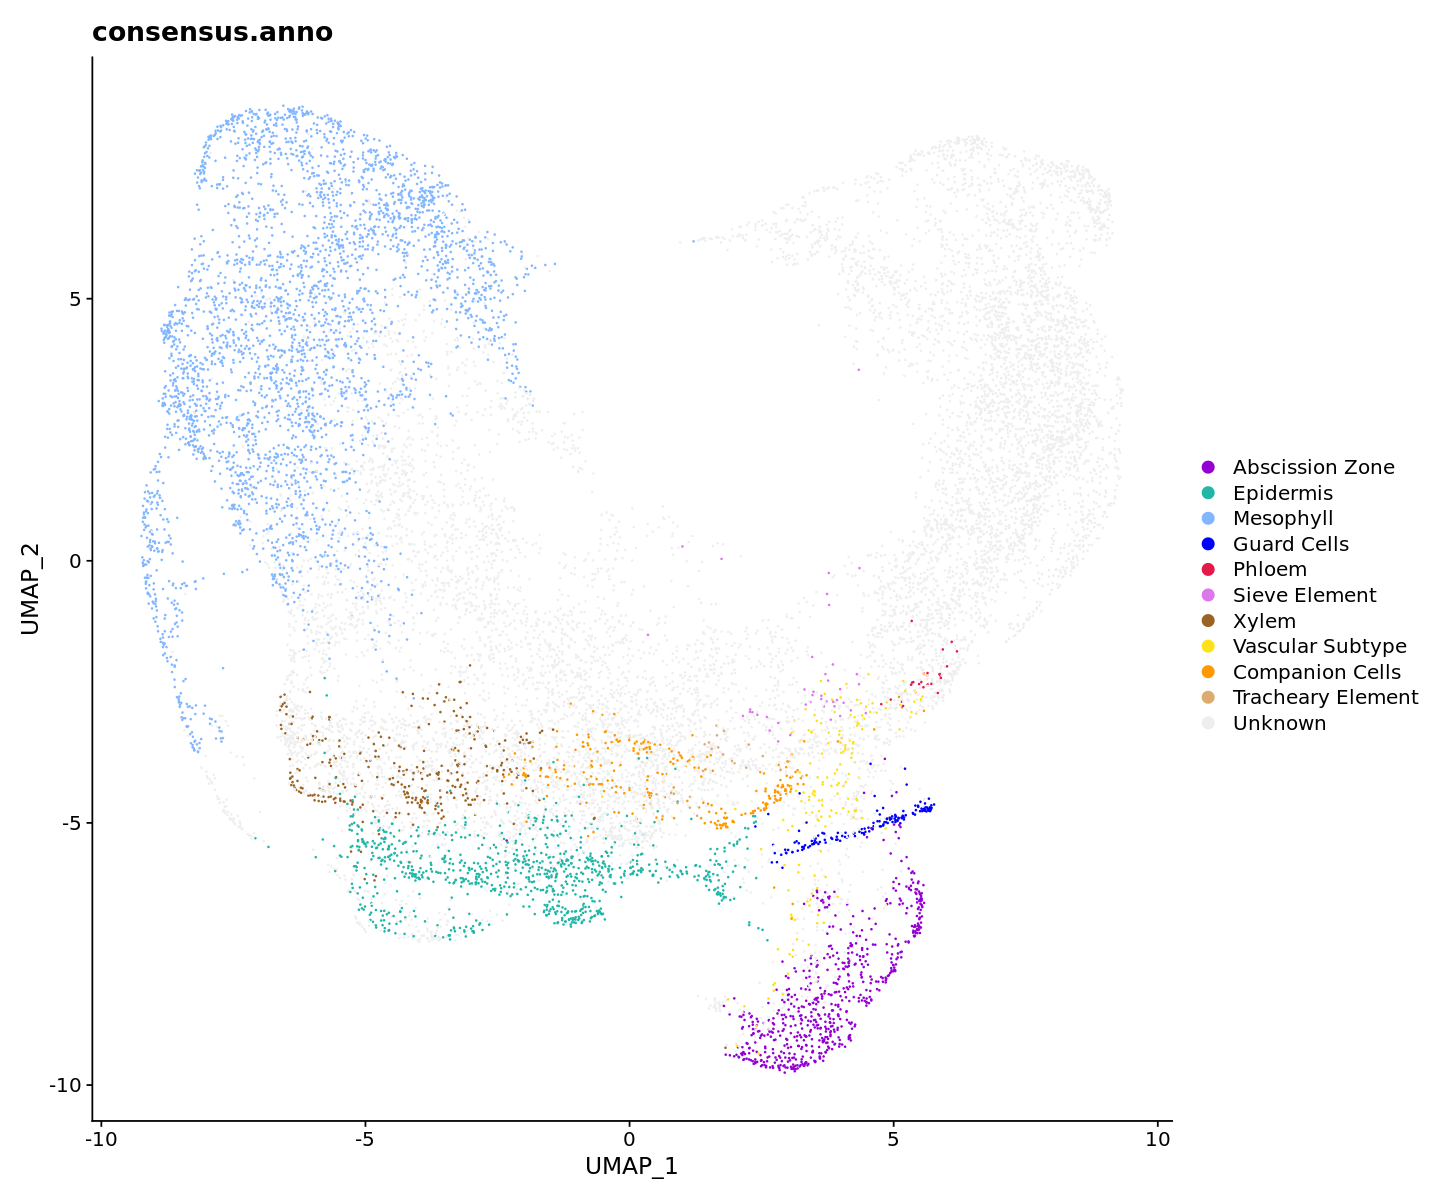

In [33]:
#Consensus Annotation
dat <- data.frame(seu_intd_wt$score.anno, seu_intd_wt$score.crude.anno)
seu_intd_wt$consensus.anno <- apply(dat,1,function(x){if (is.na(x[1])){"Unknown"} else if (is.na(x[2])){"Unknown"} else if (x[1]==x[2]){x[1]} else {"Unknown"}})
#seu_intd_wt$consensus.anno <- apply(dat,1,function(x){if(x[1]==x[2]){x[1]}else if(x[1]=="Trichoblast" & x[2]=="Atrichoblast"){"Trichoblast"}
#    else if(x[1]=="Late Metaxylem" & x[2]=="Phloem"){"Late Metaxylem"}else if(x[1]=="Cortex" & x[2]=="Sclerenchyma"){"Cortex"}
#        else if(x[1]=="Exodermis" & x[2]=="Sclerenchyma"){"Exodermis"}else if(x[1]=="Exodermis" & x[2]=="Endodermis"){"Exodermis"}
#            else if(x[1]=="Cortex" & x[2]=="Endodermis"){"Cortex"}else if(x[1]=="Pericycle" & x[2]=="Endodermis"){"Pericycle"}else if(x[1]=="Phloem" & x[2]=="Endodermis"){"Phloem"}
#                    else if(x[1]=="Late Metaxylem" & x[2]=="Endodermis"){"Late Metaxylem"}else if(x[3]=="Maturation1"|x[3]=="Maturation2"){x[2]}else {"Unknown"}})
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Epidermis", "Mesophyll", "Guard Cells", "Phloem","Sieve Element", "Xylem", "Vascular Subtype","Companion Cells","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$consensus.anno <- factor(seu_intd_wt$consensus.anno , levels = order[sort(match(unique(seu_intd_wt$consensus.anno),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$consensus.anno),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "consensus.anno", cols = color)+ggtitle("consensus.anno")

seu_intd_wt$celltype.consensus.anno <- seu_intd_wt$consensus.anno

In [42]:
trava_genes = read.csv("../data/bulk_data/trava_DE_genes.csv", header = F)
colnames(trava_genes) = c("Locus", "Celltype")

In [43]:
known.good.markers <- rbind(known.good.markers[,c(2,3)], trava_genes)

In [95]:
known.good.markers = known.good.markers[-which(known.good.markers$Locus=="AT1G77525"),] 

In [97]:

msc <- c()
for (i in as.character(unique(known.good.markers$Celltype))){
    print(i)
    if (length(known.good.markers[which(known.good.markers$Celltype== i),]$Locus)>1){
    msc <- cbind(msc, as.numeric(apply(apply(seu_intd_wt@assays$SCT@data[known.good.markers[which(known.good.markers$Celltype == i),]$Locus,], 1, zscore), 1, mean)))       
    } else {
    msc <- cbind(msc, as.numeric(zscore(seu_intd_wt@assays$SCT@data[known.good.markers[which(known.good.markers$Celltype== i),]$Locus,])))      
    }

}
colnames(msc) <- as.character(unique(known.good.markers$Celltype))
rownames(msc) <- colnames(seu_intd_wt)

[1] "Companion Cells"
[1] "Epidermis"
[1] "Guard Cells"
[1] "Mesophyll"
[1] "Phloem"
[1] "Sieve Element"
[1] "Tracheary Element"
[1] "Vascular Subtype"
[1] "Xylem"
[1] "Abscission Zone"
[1] "Carpel"
[1] "Petal"
[1] "Sepal"
[1] "Filament"
[1] "Silique"


In [98]:
# Crude
# Find clusters, here we choose Leiden clustering algorithm with resolution 0.5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
DefaultAssay(seu_intd_wt) <- "integrated"
suppressMessages(suppressWarnings(
  seu_intd_wt <- FindClusters(seu_intd_wt, resolution = 2, algorithm = 3)
))

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16169
Number of edges: 506288

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8315
Number of communities: 38
Elapsed time: 10 seconds


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


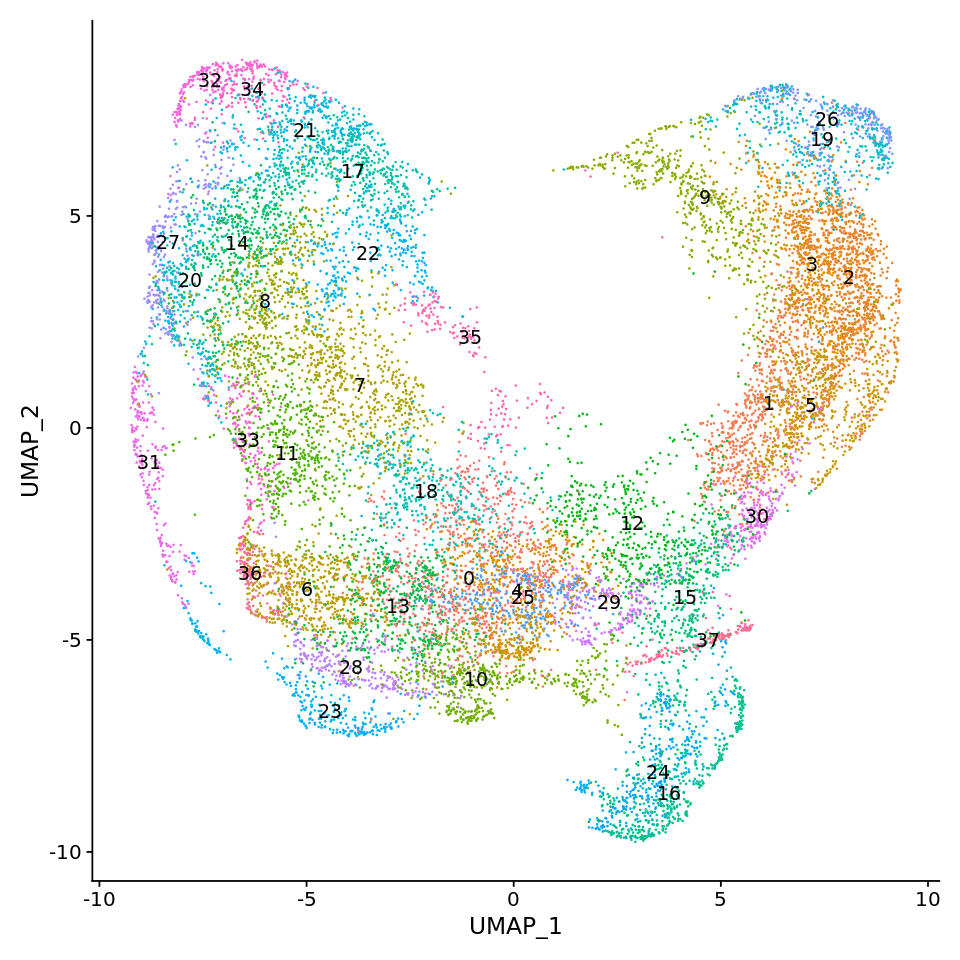

In [99]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu_intd_wt, reduction = "umap", label=TRUE)+NoLegend()

anno <- seu_intd_wt$seurat_clusters
for (i in unique(seu_intd_wt$seurat_clusters)){
    if (max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean))>0){
        ct <- names(which.max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean)))
    } else {
        ct <- "NA"
    }
        anno <- gsub(paste0("^",i,"$"), ct, anno, ignore.case = FALSE, perl = FALSE,fixed = FALSE, useBytes = FALSE)
}

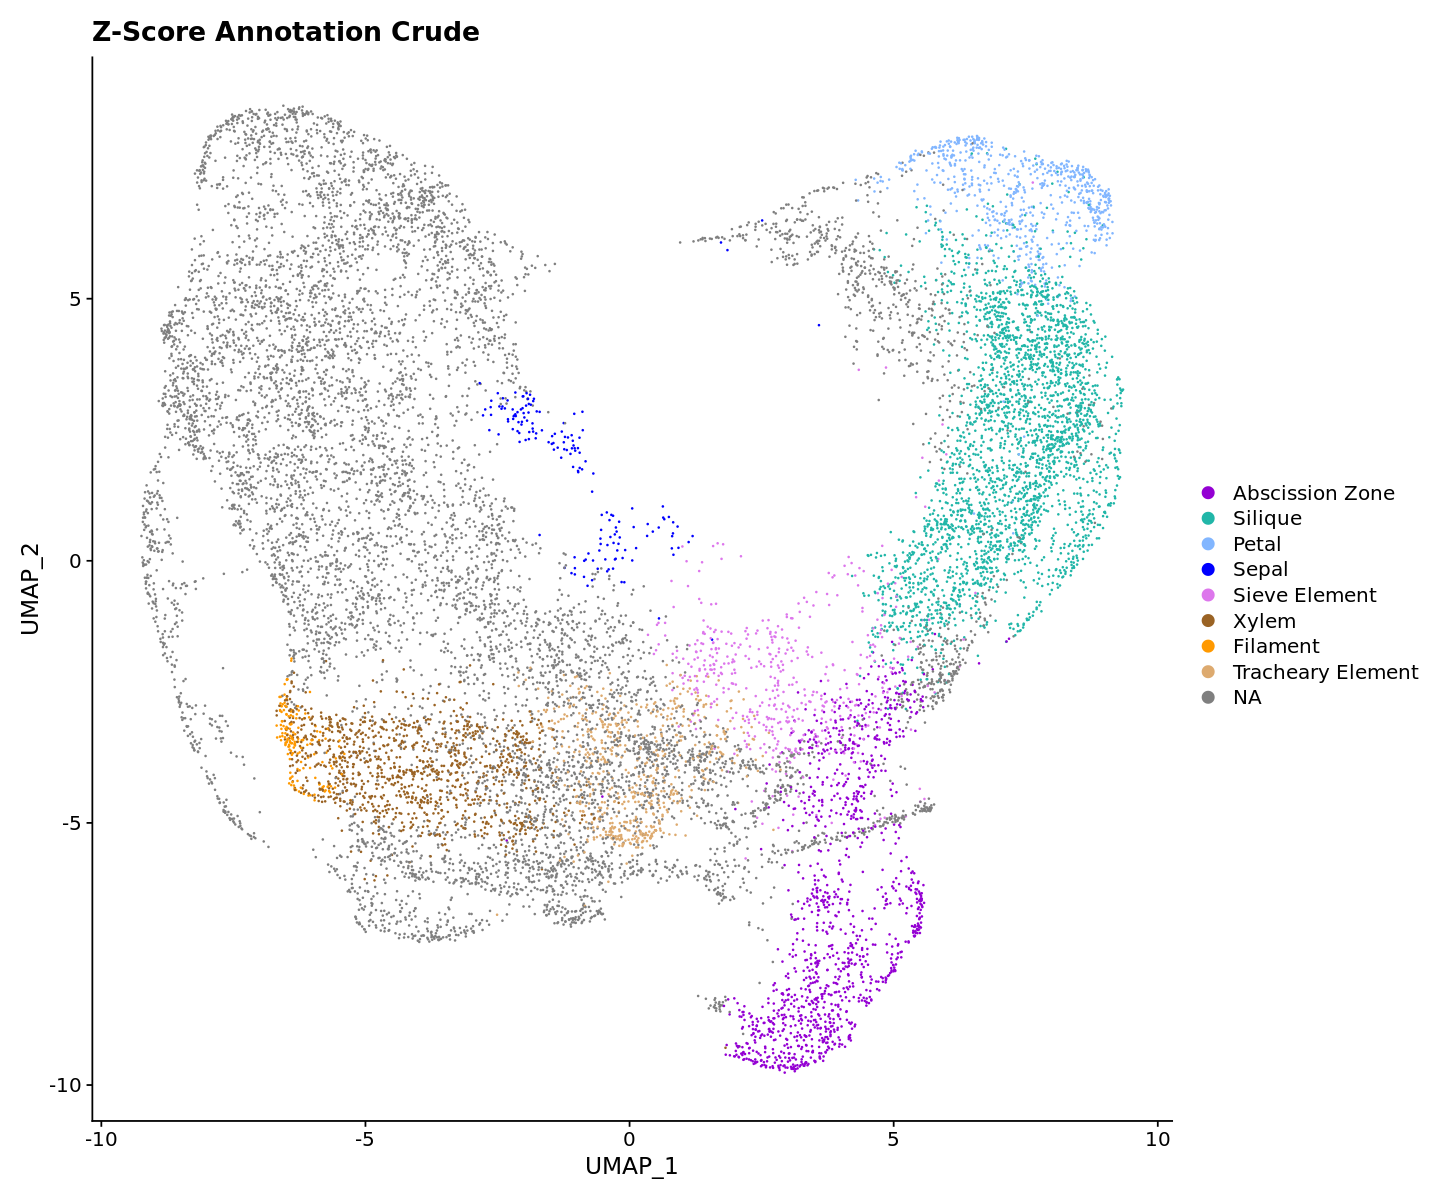

In [100]:
seu_intd_wt$score.crude.anno <- anno
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Silique", "Petal", "Sepal", "Carpel","Sieve Element", "Xylem", "Vascular Subtype","Filament","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$score.crude.anno <- factor(seu_intd_wt$score.crude.anno , levels = order[sort(match(unique(seu_intd_wt$score.crude.anno),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$score.crude.anno),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "score.crude.anno", cols = color)+ggtitle("Z-Score Annotation Crude")